In [8]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
df = pd.read_csv('../../data/df_final.csv',index_col='date', parse_dates=True)

In [10]:
df.columns

Index(['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp',
       ...
       'jpyusd_trend_lag_1', 'jpyusd_trend_lag_2', 'jpyusd_trend_lag_3',
       'jpyusd_trend_lag_4', 'jpyusd_trend_lag_5', 'gbpusd_trend_lag_1',
       'gbpusd_trend_lag_2', 'gbpusd_trend_lag_3', 'gbpusd_trend_lag_4',
       'gbpusd_trend_lag_5'],
      dtype='object', length=113)

# XGB

## EURUSD

In [11]:
# Definir la variable objetivo
target = 'eurusd_trend'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

# Separar características (X) y objetivo (y)
X = df.drop(columns=t)
y = df[target]

In [12]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Dividir los datos en conjuntos de entrenamiento y prueba respetando la secuencia temporal
test_size = 0.2
n_test = int(len(df) * test_size)
X_train, X_test = X_scaled[:-n_test], X_scaled[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]


In [14]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0)
    }

    # Validación cruzada adaptada a series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_index, test_index in tscv.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        model = xgb.XGBClassifier(**param)
        model.fit(X_train_fold, y_train_fold)
        
        preds = model.predict(X_test_fold)
        accuracy = np.mean(preds == y_test_fold)
        scores.append(accuracy)

    return np.mean(scores)


In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)


[I 2024-06-26 08:31:23,687] A new study created in memory with name: no-name-c06d15f2-9912-49b3-b89f-a7b5808a9418
C:\Users\usuario\AppData\Local\Temp\ipykernel_32472\3640678146.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train_fold, y_test_fold = y[train_index], y[test_index]
[I 2024-06-26 08:31:25,690] Trial 0 finished with value: 0.5033333333333333 and parameters: {'n_estimators': 270, 'learning_rate': 0.07900639369805286, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.5025465323191363, 'colsample_bytree': 0.8341966246322388, 'gamma': 0.5817067889725874, 'lambda': 8.39804329603599, 'alpha': 2.0550130821220884}. Best is trial 0 with value: 0.5033333333333333.
[I 2024-06-26 08:31:26,640] Trial 1 finished with value: 0.5057575757575756 and parameters: {'n_estimators': 204, 'learning_

Best hyperparameters:  {'n_estimators': 267, 'learning_rate': 0.09443680699577105, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.7605447008363928, 'colsample_bytree': 0.6180620712080047, 'gamma': 0.4385442645601312, 'lambda': 1.5697526431923081, 'alpha': 0.3486822969942676}


In [16]:
best_params = study.best_params

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(alpha=0.3486822969942676, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6180620712080047, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4385442645601312,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.5697526431923081,
              learning_rate=0.09443680699577105, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=267, n_jobs=None, ...)

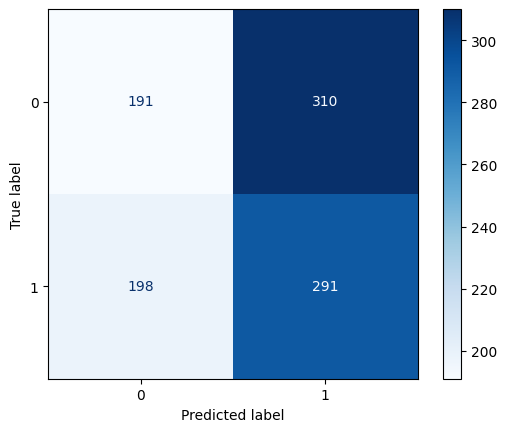

              precision    recall  f1-score     support
0              0.491003  0.381238  0.429213  501.000000
1              0.484193  0.595092  0.533945  489.000000
accuracy       0.486869  0.486869  0.486869    0.486869
macro avg      0.487598  0.488165  0.481579  990.000000
weighted avg   0.487639  0.486869  0.480944  990.000000


In [17]:
# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calcular y mostrar las métricas del modelo
report = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)


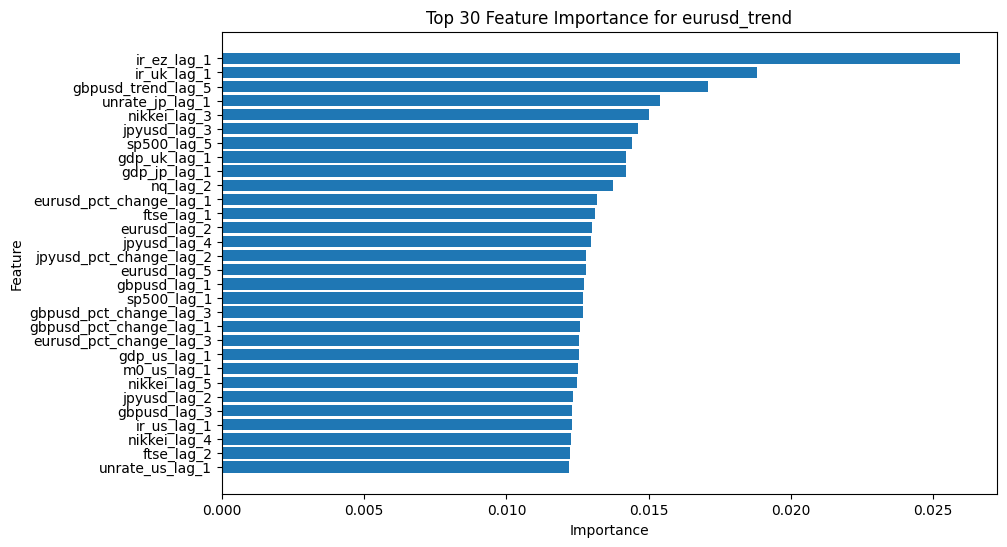

In [18]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 20 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 20 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()

## GBPUSD

In [19]:
# Definir la variable objetivo
target = 'gbpusd_trend'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

# Separar características (X) y objetivo (y)
X = df.drop(columns=t)
y = df[target]

In [20]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba respetando la secuencia temporal
test_size = 0.2
n_test = int(len(df) * test_size)
X_train, X_test = X_scaled[:-n_test], X_scaled[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]


In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)

[I 2024-06-26 08:33:02,642] A new study created in memory with name: no-name-24a5fb0e-8819-4dcf-a530-7cf11d521b76
C:\Users\usuario\AppData\Local\Temp\ipykernel_32472\3640678146.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train_fold, y_test_fold = y[train_index], y[test_index]
[I 2024-06-26 08:33:03,306] Trial 0 finished with value: 0.4948484848484848 and parameters: {'n_estimators': 113, 'learning_rate': 0.028401333137599107, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.945846776480566, 'colsample_bytree': 0.8692327485763465, 'gamma': 1.534054429168128, 'lambda': 5.434798300798737, 'alpha': 9.040645918041655}. Best is trial 0 with value: 0.4948484848484848.
[I 2024-06-26 08:33:04,497] Trial 1 finished with value: 0.49787878787878787 and parameters: {'n_estimators': 850, 'learning_r

Best hyperparameters:  {'n_estimators': 594, 'learning_rate': 0.05874154204063589, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.9771700893414108, 'colsample_bytree': 0.8807534108978807, 'gamma': 2.2469356989938367, 'lambda': 4.610024272811612, 'alpha': 8.191906683628883}


In [23]:
best_params = study.best_params

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(alpha=8.191906683628883, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8807534108978807, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.2469356989938367,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=4.610024272811612,
              learning_rate=0.05874154204063589, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=594, n_jobs=None, ...)

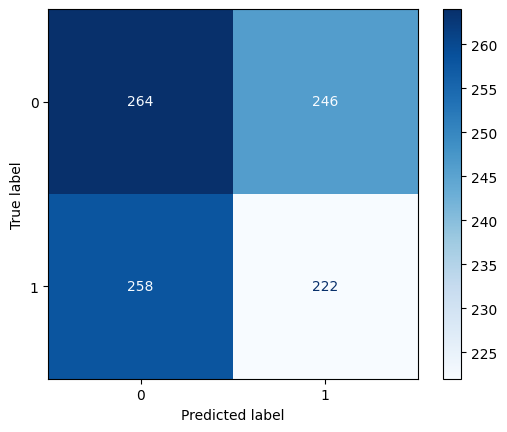

              precision    recall  f1-score     support
0              0.505747  0.517647  0.511628  510.000000
1              0.474359  0.462500  0.468354  480.000000
accuracy       0.490909  0.490909  0.490909    0.490909
macro avg      0.490053  0.490074  0.489991  990.000000
weighted avg   0.490529  0.490909  0.490647  990.000000


In [24]:
# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calcular y mostrar las métricas del modelo
report = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)


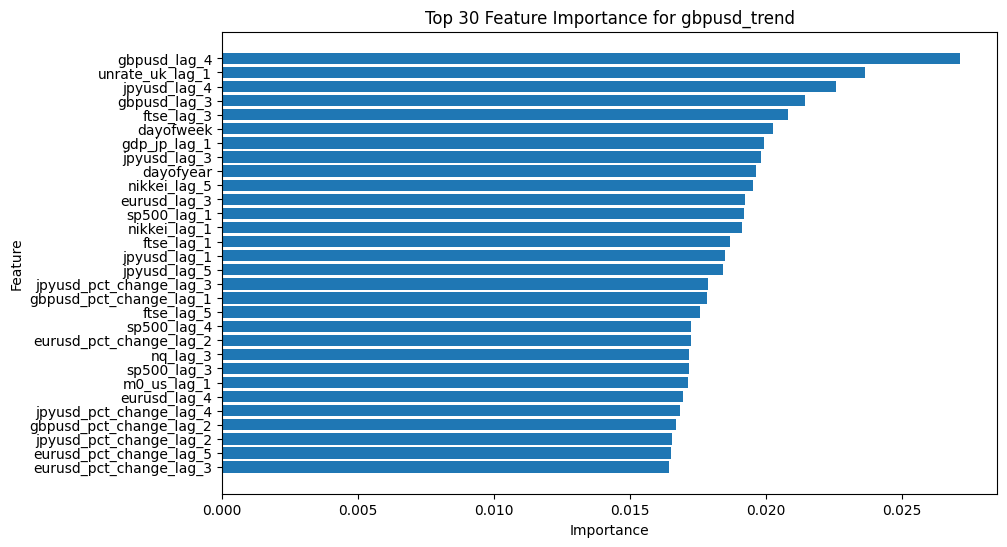

In [25]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 30 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 30 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()

## JPYUSD

In [26]:
# Definir la variable objetivo
target = 'jpyusd_trend'

# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

# Separar características (X) y objetivo (y)
X = df.drop(columns=t)
y = df[target]

In [27]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
# Dividir los datos en conjuntos de entrenamiento y prueba respetando la secuencia temporal
test_size = 0.2
n_test = int(len(df) * test_size)
X_train, X_test = X_scaled[:-n_test], X_scaled[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]


In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)

[I 2024-06-26 08:34:06,923] A new study created in memory with name: no-name-2f867460-8c4f-4a33-bf25-e5a77e9fb493
C:\Users\usuario\AppData\Local\Temp\ipykernel_32472\3640678146.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train_fold, y_test_fold = y[train_index], y[test_index]
[I 2024-06-26 08:34:08,264] Trial 0 finished with value: 0.5066666666666666 and parameters: {'n_estimators': 505, 'learning_rate': 0.09437612122176262, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.7876705636346771, 'colsample_bytree': 0.9057906860489255, 'gamma': 1.2491133510618602, 'lambda': 7.396871164110901, 'alpha': 8.229842852245092}. Best is trial 0 with value: 0.5066666666666666.
[I 2024-06-26 08:34:09,764] Trial 1 finished with value: 0.516060606060606 and parameters: {'n_estimators': 744, 'learning_ra

Best hyperparameters:  {'n_estimators': 999, 'learning_rate': 0.03655869084383348, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6124745169827638, 'colsample_bytree': 0.9973814246638983, 'gamma': 3.450948152821176, 'lambda': 2.4290518595260076, 'alpha': 6.402984891461612}


In [30]:
best_params = study.best_params

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(alpha=6.402984891461612, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9973814246638983, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.450948152821176,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.4290518595260076,
              learning_rate=0.03655869084383348, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=999, n_jobs=None, ...)

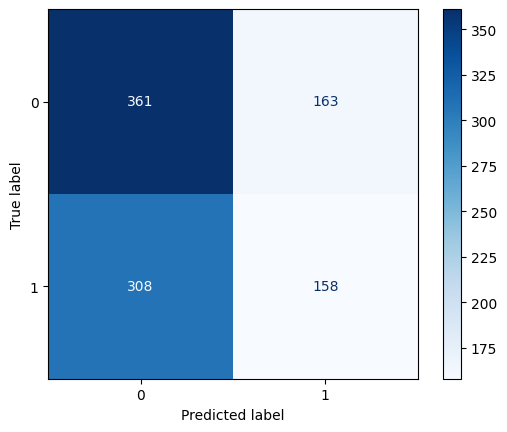

              precision    recall  f1-score     support
0              0.539611  0.688931  0.605197  524.000000
1              0.492212  0.339056  0.401525  466.000000
accuracy       0.524242  0.524242  0.524242    0.524242
macro avg      0.515912  0.513994  0.503361  990.000000
weighted avg   0.517300  0.524242  0.509327  990.000000


In [31]:
# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calcular y mostrar las métricas del modelo
report = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)


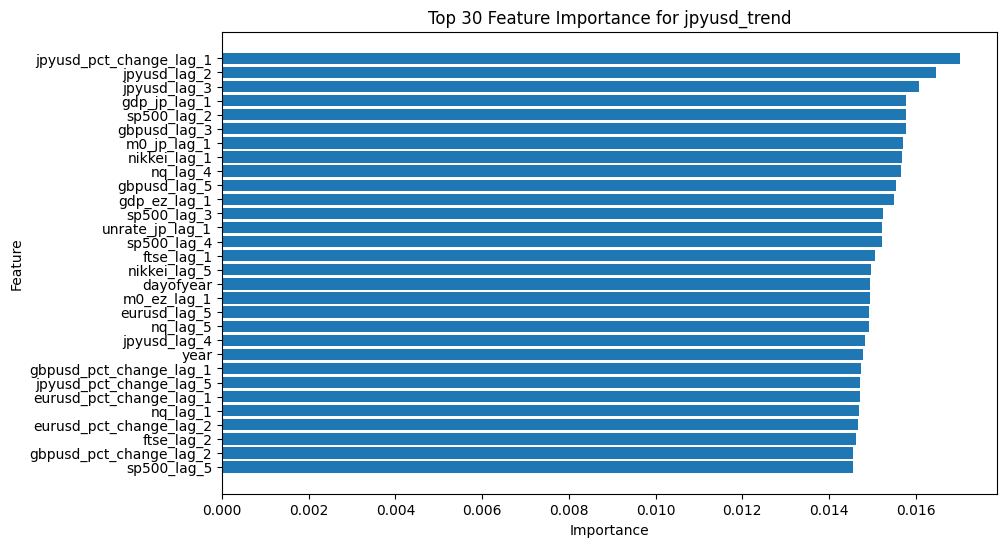

In [32]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 30 características más importantes
top_30_features = importance_df.head(30)

# Graficar la importancia de las 30 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['feature'], top_30_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Feature Importance for {target}')
plt.gca().invert_yaxis()
plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_32472\2974546702.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y='feature', data=top_30_features, palette='Greys_r')


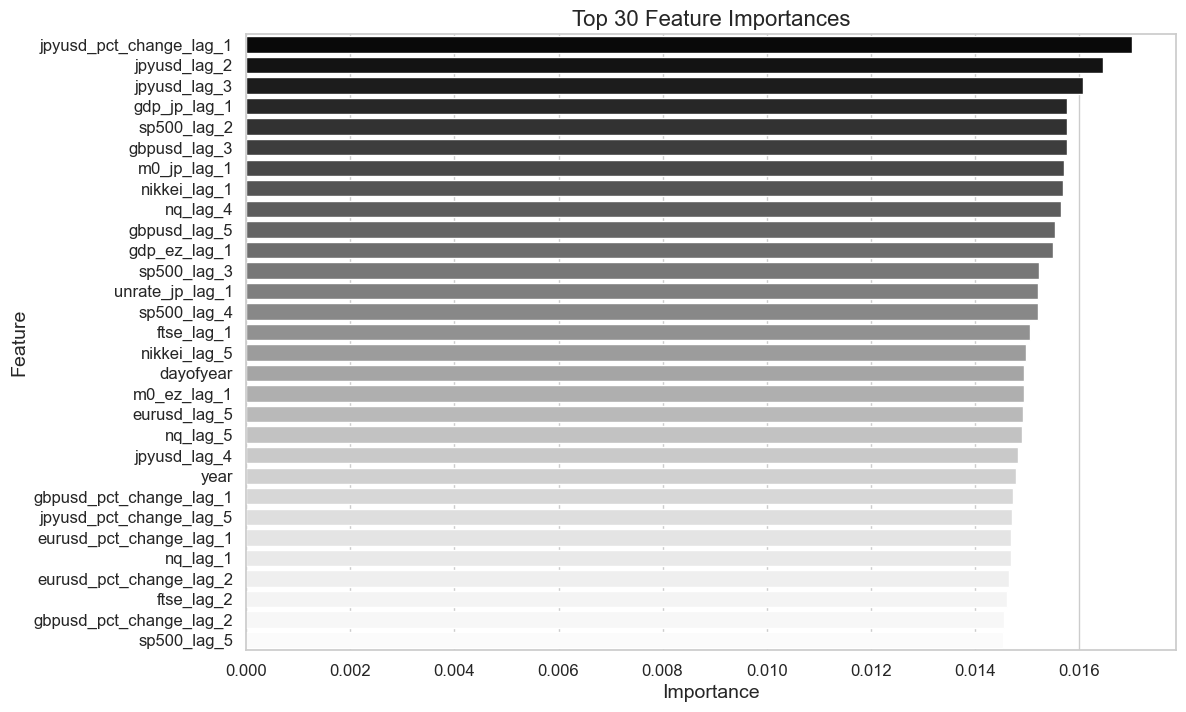

In [35]:
# Obtener la importancia de las características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las 30 características más importantes
top_30_features = importance_df.head(30)

# Configuración de estilo de seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='importance', y='feature', data=top_30_features, palette='Greys_r')

# Etiquetas y título en inglés
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top 30 Feature Importances', fontsize=16)

# Ajustar la visibilidad de las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la gráfica
plt.show()